# TopN model + mask generation:
## Purpose: 
## 1. validate that baseline non-linear model has very good topN accuracy
## 2. create masking algorithm for distinguishing specificly top 2 classes 
### a. one mask for each pair - O(nClasses^2) masks
### b. one mask for each class - nClasses masks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import time
import sys
import math
import numpy as np
import random
import joblib
from scipy import stats
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import copy

import Config
from Config import *
import Dataloader as DL
import HD_basis as HDB
import HD_encoder as HDE
import HD_classifier as HDC


In [3]:
# train data. with retrain
def train(hdc, traindata, trainlabels, testdata, testlabels, param = Config.config):
    train_accs = []
    test_accs = []
    for _ in tqdm_notebook(range(param["epochs"]), desc='epochs'):
        train_accs.append(hdc.fit(traindata, trainlabels, param))
        test_accs.append(hdc.test(testdata, testlabels, param["kernel"]))
        if len(train_accs) % 5 == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
        if train_accs[-1] == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
            break
    return np.asarray(train_accs), np.asarray(test_accs)

In [4]:
# train data. with retrain
def train_masks(hdc, traindata, trainlabels, testdata, testlabels, param = Config.config):
    train_accs = []
    test_accs = []
    
    for _ in range(5):
        train_accs.append(hdc.fit(traindata, trainlabels, param))
        test_accs.append(hdc.test(testdata, testlabels, param["kernel"]))
        if len(train_accs) % 5 == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
        if train_accs[-1] == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
            break
    
    
    print("Train memasks")
    for _ in tqdm_notebook(range(param["epochs"]), desc='epochs'):
        train_accs.append(hdc.fit_mask(traindata, trainlabels, param))
        test_accs.append(hdc.test(testdata, testlabels, param["kernel"]))
        if len(train_accs) % 5 == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
        if train_accs[-1] == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
            break
    return np.asarray(train_accs), np.asarray(test_accs)

In [5]:
dl = DL.Dataloader()
nFeatures, nClasses, traindata, trainlabels, testdata, testlabels = dl.getParam()


Loading dataset UCIHAR from UCIHAR
Loading train data... train data of shape (6213, 561) loaded
Loading test data...  test  data of shape (1554, 561) loaded
Data Loaded. Num of features = 561 Num of Classes = 12

In [6]:
#Data shuffling 
shuf_train = np.random.permutation(len(traindata))
traindata = traindata[shuf_train]
trainlabels = trainlabels[shuf_train]

shuf_test = np.random.permutation(len(testdata))
testdata = testdata[shuf_test]
testlabels = testlabels[shuf_test]

In [7]:
traindata = traindata[:10000]
testdata = testdata[:5000]

In [8]:
param = Config.config
param["nFeatures"] = nFeatures
param["nClasses"] = nClasses
print(param)

{'data_location': '../dataset/', 'directory': 'UCIHAR', 'dataset': 'UCIHAR', 'D': 100, 'vector': 'Gaussian', 'mu': 0, 'sigma': 1, 'binarize': 0, 'lr': 1, 'sparse': 0, 's': 0.1, 'binaryModel': 0, 'checkpoints': False, 'kernel': <Kernel_T.COS: 1>, 'width': None, 'height': None, 'nLayers': 5, 'uniform_dim': 1, 'uniform_ker': 1, 'dArr': None, 'k': 3, 'kArr': None, 'one_shot': 0, 'data_percentages': [1.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], 'train_percent': 1, 'dropout': 0, 'drop_percentages': [0, 0.1, 0.2, 0.5], 'dropout_rate': 0, 'update_type': <Update_T.FULL: 1>, 'iter_per_trial': 3, 'iter_per_encoding': 5, 'epochs': 80, 'nFeatures': 561, 'nClasses': 12}


# Sample code to train a model

In [15]:
################# VANILLA #################
hdb = HDB.HD_basis(Config.Generator_T.Vanilla, param)
basis = hdb.getBasis()
bid = hdb.getParam()["id"]
# Update param with bid
param = hdb.getParam()
print(bid)

Generating vanilla HD basis of shape... 


9238


(200, 561)
Encoding time: 0.02689337730407715 


In [16]:
# Retrieve info upto basis generator, given correct bid
#bid = 6679
#basis, param = HDB.loadBasis("base_%d.pkl"%bid)

In [17]:
hde = HDE.HD_encoder(basis)

trainencoded = hde.encodeData(traindata)
#HDE.saveEncoded(trainencoded, trainlabels, bid, "train")

testencoded = hde.encodeData(testdata)
#HDE.saveEncoded(testencoded, testlabels, bid, "test")

Encoding data of shape (6213, 561)


Time spent: 0 sec
Encoding data of shape (1554, 561)


Time spent: 0 sec


In [18]:
# Retrieve info upto encoder, given correct bid
#bid = 6679
#basis, param = HDB.loadBasis("base_%d.pkl"%bid)
#trainencoded, trainlabels = HDE.loadEncoded("encoded_%d_train.pkl"%bid)
#testencoded, testlabels = HDE.loadEncoded("encoded_%d_test.pkl"%bid)

In [19]:
hdc = HDC.HD_classifier(param["D"], param["nClasses"], bid)
train_acc, test_acc = train(hdc, trainencoded, trainlabels, testencoded, testlabels, param)

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 1), ('kernel', <Kernel_T.COS: 1>)] 


Train: 0.721552 	 	 Test: 0.428571
Train: 0.878320 	 	 Test: 0.822394
Train: 0.908418 	 	 Test: 0.922780
Train: 0.920650 	 	 Test: 0.945946
Train: 0.935458 	 	 Test: 0.938867
Train: 0.940286 	 	 Test: 0.920849
Train: 0.950427 	 	 Test: 0.923423
Train: 0.954772 	 	 Test: 0.940798
Train: 0.951392 	 	 Test: 0.948520
Train: 0.956704 	 	 Test: 0.953668
Train: 0.959440 	 	 Test: 0.951737
Train: 0.961532 	 	 Test: 0.922136
Train: 0.961532 	 	 Test: 0.941441
Train: 0.961532 	 	 Test: 0.958172
Train: 0.958796 	 	 Test: 0.957529
Train: 0.968453 	 	 Test: 0.957529



# Top n accuracy

In [9]:
def topn_suit(traindata, trainlabels, testdata, testlabels, param):
    hdb = HDB.HD_basis(Config.Generator_T.Vanilla, param)
    basis = hdb.getBasis()
    bid = hdb.getParam()["id"]
    param = hdb.getParam()
    
    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    
    hdc = HDC.HD_classifier(param["D"], param["nClasses"], bid)
    train_acc, test_acc = train(hdc, trainencoded, trainlabels, testencoded, testlabels, param)
    accs = []
    cmps = []
    for k in range(5):
        accs.append(hdc.test_topn(testencoded, testlabels, k+1))
        cmps.append(hdc.predict_topn(testencoded, k+1))
        print("Top %d accuracy: "%(k+1), accs[-1])
    return accs, cmps

In [10]:
Ds = [200, 500, 1000]
accs_D = dict()
cmps_D = dict()
for D in Ds:
    param["D"] = D
    accs_D[D], cmps_D[D] = topn_suit(traindata, trainlabels, testdata, testlabels, param)
param["D"] = Config.config["D"]

Generating vanilla HD basis of shape... 

(200, 561)
Encoding time: 0.029904842376708984 
Encoding data of shape (6213, 561)


Time spent: 0 sec
Encoding data of shape (1554, 561)


Time spent: 0 sec
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 1), ('kernel', <Kernel_T.DOT: 0>)] 


Train: 0.713021 	 	 Test: 0.850064
Train: 0.894254 	 	 Test: 0.862934
Train: 0.912442 	 	 Test: 0.911840
Train: 0.920650 	 	 Test: 0.907979



KeyboardInterrupt: 

In [ ]:
for D in accs_D.keys():
    print(D)
    for i in range(len(accs_D[D])):
        print("Top %d Accuracy:"%(i+1), accs_D[D][i])

# Mask generation: 2d masks

In [9]:
hdb = HDB.HD_basis(Config.Generator_T.Vanilla, param)
basis = hdb.getBasis()
bid = hdb.getParam()["id"]
param = hdb.getParam()

hde = HDE.HD_encoder(basis)
trainencoded = hde.encodeData(traindata)
testencoded = hde.encodeData(testdata)

hdc = HDC.HD_classifier(param["D"], param["nClasses"], bid)
train_acc, test_acc = train(hdc, trainencoded, trainlabels, testencoded, testlabels, param)


Generating vanilla HD basis of shape... 

(100, 561)
Encoding time: 0.025930404663085938 
Encoding data of shape (6213, 561)


Time spent: 0 sec
Encoding data of shape (1554, 561)


Time spent: 0 sec
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 1), ('kernel', <Kernel_T.COS: 1>)] 


Train: 0.683728 	 	 Test: 0.798584
Train: 0.849509 	 	 Test: 0.875161
Train: 0.883309 	 	 Test: 0.890605
Train: 0.886689 	 	 Test: 0.893179
Train: 0.894093 	 	 Test: 0.906692
Train: 0.904072 	 	 Test: 0.916345
Train: 0.917431 	 	 Test: 0.931145
Train: 0.918558 	 	 Test: 0.879665
Train: 0.922421 	 	 Test: 0.916345
Train: 0.921455 	 	 Test: 0.916345
Train: 0.916787 	 	 Test: 0.925997
Train: 0.926445 	 	 Test: 0.931145
Train: 0.922743 	 	 Test: 0.911197
Train: 0.931112 	 	 Test: 0.911840
Train: 0.931756 	 	 Test: 0.875804
Train: 0.924352 	 	 Test: 0.922780



In [10]:
fst_r, snd_r = hdc.analyze(trainencoded, trainlabels)
#fst_r, snd_r = hdc.analyze(testencoded, testlabels)

print(len(fst_r), len(snd_r))
beta = max(snd_r)
fst_r = fst_r[fst_r <= beta]
print(len(fst_r))


5759 454
4651


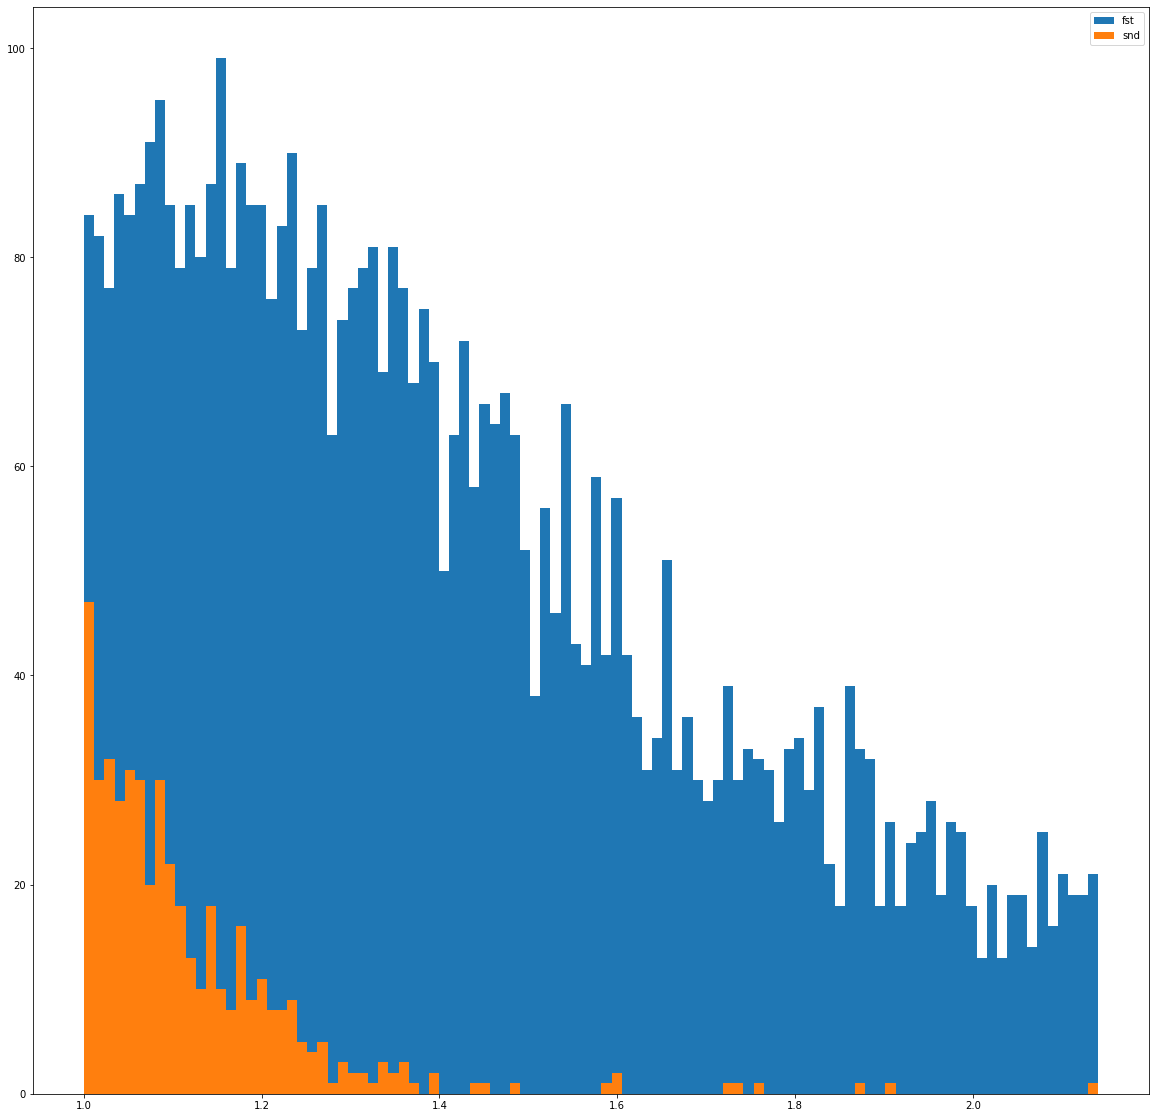

In [11]:
plt.figure(figsize = (20, 20))
# No more overlap
plt.hist(np.append(fst_r,snd_r), bins = 100, label = "fst")
plt.hist(snd_r, bins = 100, label = "snd")
plt.legend()

In [23]:
percent = 0.25
dominance = 1.5
mask_t = "b" # b for binary, o for original 
mask_d = 2

In [24]:
hdc.make_mask(trainencoded, trainlabels, dominance)
hdc.prep_mask(percent)

In [25]:
#fst_mr, snd_mr = hdc.analyze_topn(testencoded, testlabels, dominance, mask_t, mask_d)
fst_mr, snd_mr, fst_scs, snd_scs = hdc.analyze_topn(trainencoded, trainlabels, dominance, mask_t, mask_d)

Analyzing score with mask type b 2


C:\HDComputing\TopnHD\HD_classifier.py:695: RuntimeWarning: invalid value encountered in double_scalars
  ratio = fst_sc/snd_sc


In [26]:
print(len(fst_mr), len(snd_mr))
print(len(fst_scs), len(snd_scs))
print(fst_mr)
print(snd_mr)
print(fst_scs)
print(snd_scs)
#fst_abs = len(fst_mr[fst_mr == 100000000000000])
#snd_abs = len(snd_mr[snd_mr == 100000000000000])
#fst_mr = fst_mr[fst_mr < 100000000000000]
#snd_mr = snd_mr[snd_mr < 100000000000000]
#print(fst_abs, snd_abs)

2940 427
2940 427
[-0.17554728 -1.12648134 -0.85837862 ... -0.13113994 -0.86899321
 -1.14957616]
[ -0.91946269  -0.85428773  -7.41794852  -0.8601571   -1.06949366
  -7.02840297  -0.87598926  -4.48908652  -0.74604467  -0.88675191
  -0.86843311  -0.86169045  -0.80819737  -0.87888772  -0.86125952
  -4.84052701  -0.95669848  -5.10476112  -0.94490342  -0.92735039
  -1.11148649  -0.8839023   -1.30871418  -0.89273359  -0.85374258
  -0.85903304  -0.8841337   -0.86630482  -0.86121806  -1.1333047
  -0.89094701  -0.87398529  -0.91713072  -0.86460501  -3.87403596
  -1.122603    -1.14891348  -3.68871948  -0.87583522  -0.8516264
  -2.54888332  -2.34608862  -0.79392192  -0.8603488   -4.76668938
  -0.87811388  -5.90758115  -1.14906567  -0.87706881  -0.89198849
  -0.86475938  -7.96094391  -0.98751652  -0.87949611 -35.42619702
  -2.40030629  -1.18488388  -0.86594518  -4.04570287  -0.86612312
  -5.07916276  -0.86412376  -0.84256776  -0.86391158  -0.8781944
  -0.86766956  -0.8881912   -0.87793463  -1.1156

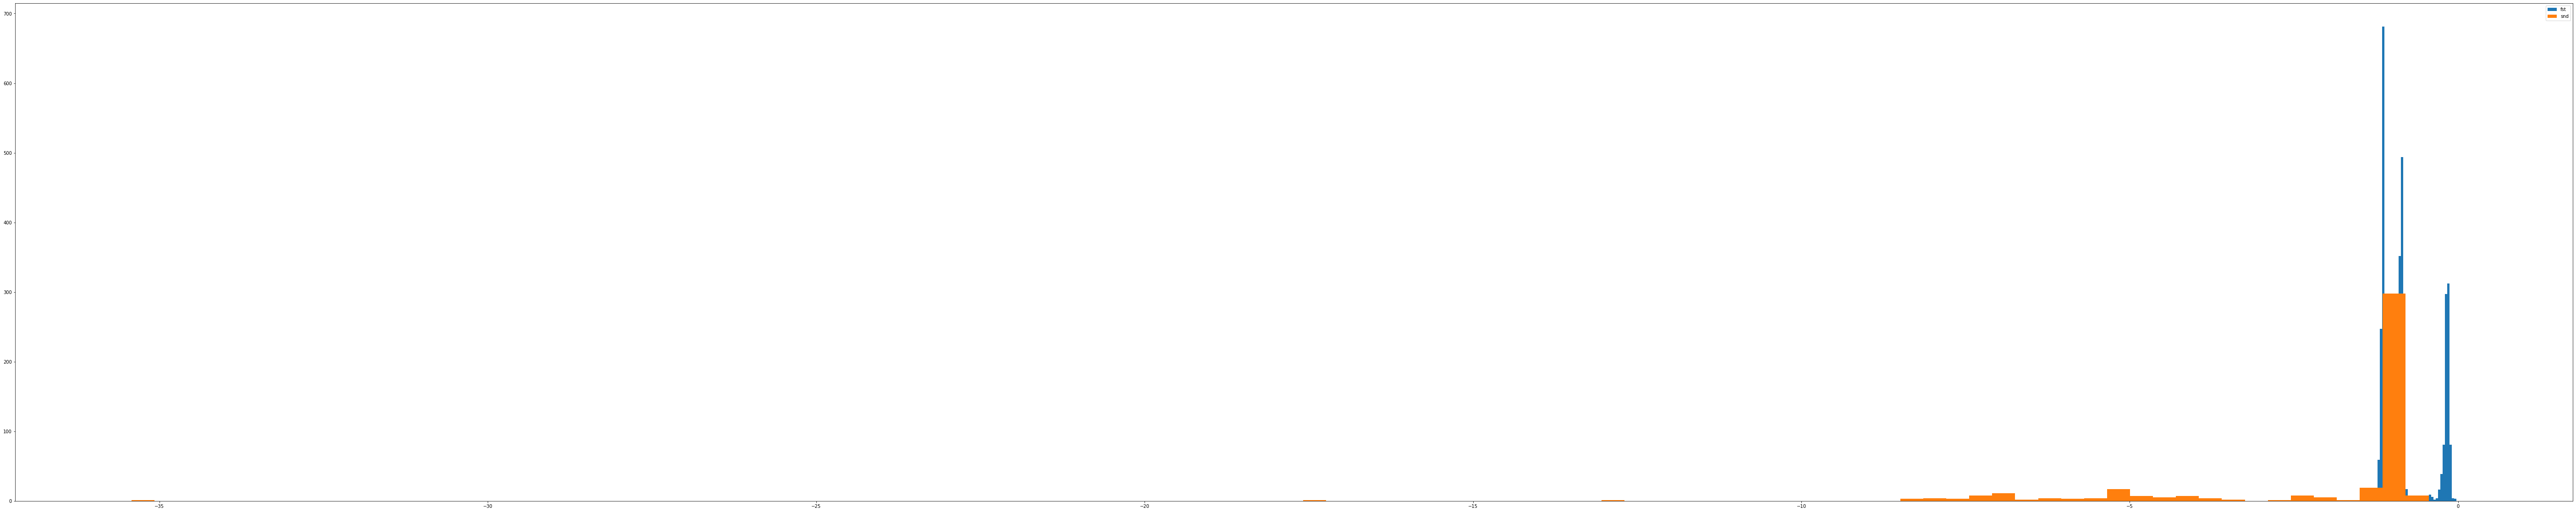

In [28]:
plt.figure(figsize = (100, 20))
plt.hist(np.append(fst_mr,snd_mr), bins = 1000, label = "fst")
plt.hist(snd_mr, bins = 100, label = "snd")
plt.legend()

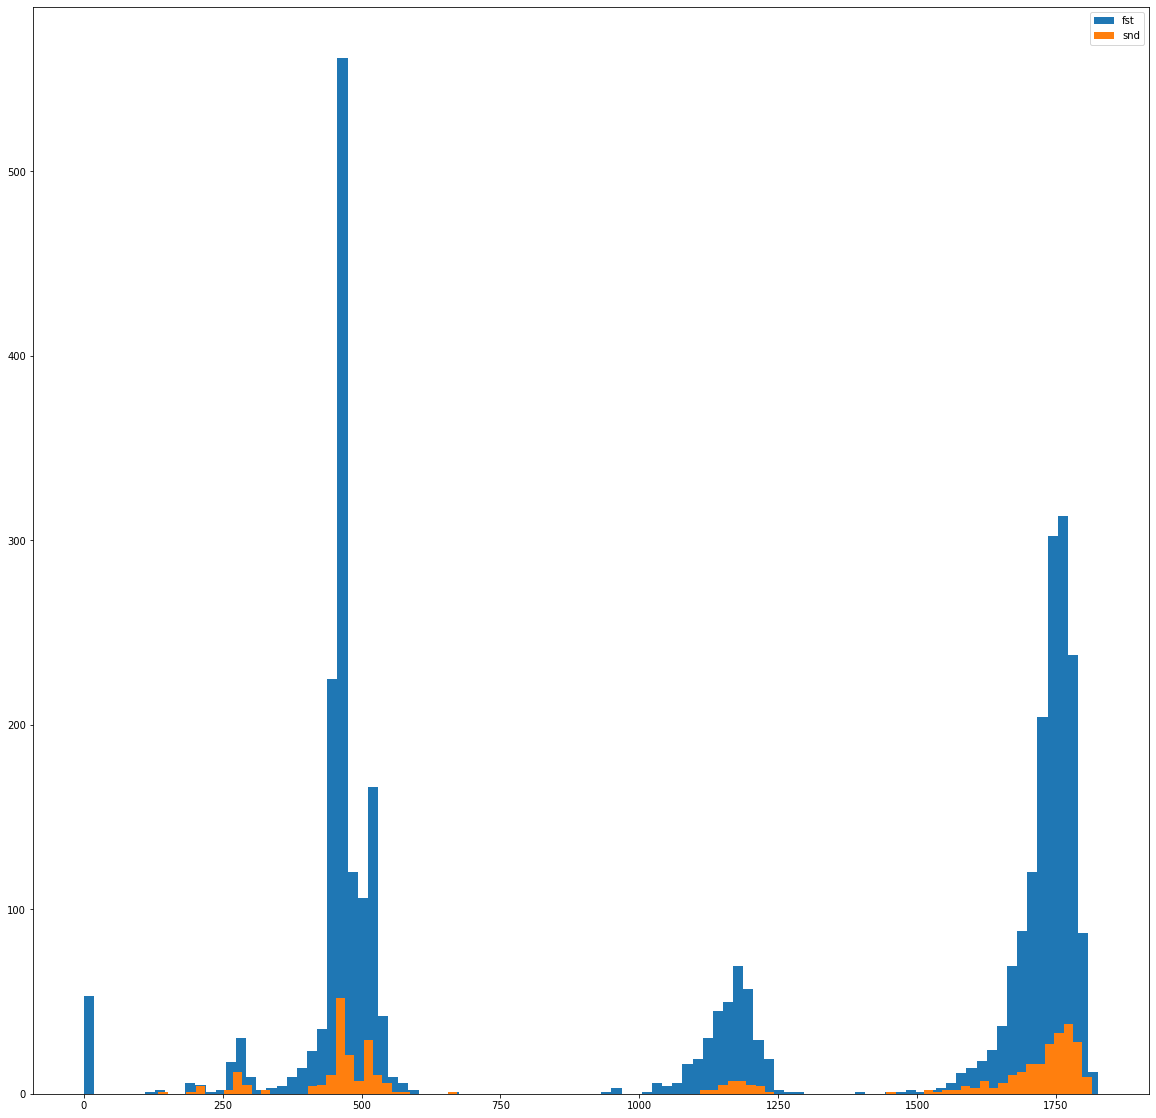

In [22]:
plt.figure(figsize = (20, 20))
plt.hist(np.append(fst_scs,snd_scs), bins = 100, label = "fst")
plt.hist(snd_scs, bins = 100, label = "snd")
plt.legend()

In [18]:
threshold = 1

In [19]:

correct, c_1, c_2, c_r, w_1, w_2, w_3, count, mat =hdc.test_mask(testencoded, testlabels, threshold, dominance, mask_t, mask_d)

Wrongly selected the first:
4 3
1918.2517445355202
Wrongly selected the first:
0 2
1042.6329691254236
Wrongly selected the first:
0 2
963.9830578962737
Wrongly selected the first:
3 4
1952.167039807035
Wrongly selected the first:
4 3
1.4924473490108487
Wrongly selected the first:
1 2
983.6712719565974
Wrongly selected the first:
0 1
1.470787472807764
Wrongly selected the first:
3 4
1.5033946868613772
Wrongly selected the first:
3 4
1909.16061057148
Wrongly selected the first:
3 4
1865.0039546177654
Wrongly selected the first:
3 4
1.6249916215837927
Found untrained mask (4, 5) during testing
Their submasks starts with:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Selecting fst by default
Wrongly selected the first:
3 4
1918.8169334976449
Wrongly selected the first:
4 6
562.6057822076596
Wrongly selected the first:
9 11
1.696956759484879
Wrongly selected the first:
10 8
526.8375684432592
Wrongly selected the first:
3 4
1919.4206407661213
Wrongly selected the first:
5 3

In [20]:
print("Correct: ",correct)
print("First is Correct: ", c_1)
print("Wrong second is selected: ", w_1)
print("Second is Correct: ", c_2)
print("Correct Second is selected: ", c_r)
print("Wrong first is selected: ", w_2)
print("Out of top 2: ", w_3)
print("Net increase in correct cases and accuracy: ", c_r-w_1, (c_r-w_1)/count)
print("Potential increase in correct cases and accuracy: ", c_2, c_2/count)
print("Total cases:", count)
print("Matrix:\n", mat)

Correct:  1490
First is Correct:  1490
Wrong second is selected:  0
Second is Correct:  54
Correct Second is selected:  0
Wrong first is selected:  54
Out of top 2:  3
Net increase in correct cases and accuracy:  0 0.0
Potential increase in correct cases and accuracy:  54 0.03490627020038785
Total cases: 1547
Matrix:
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 29.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  0.  0.]]


1463 91
1463
Analyzing score with mask type o 2
289 68
289 68


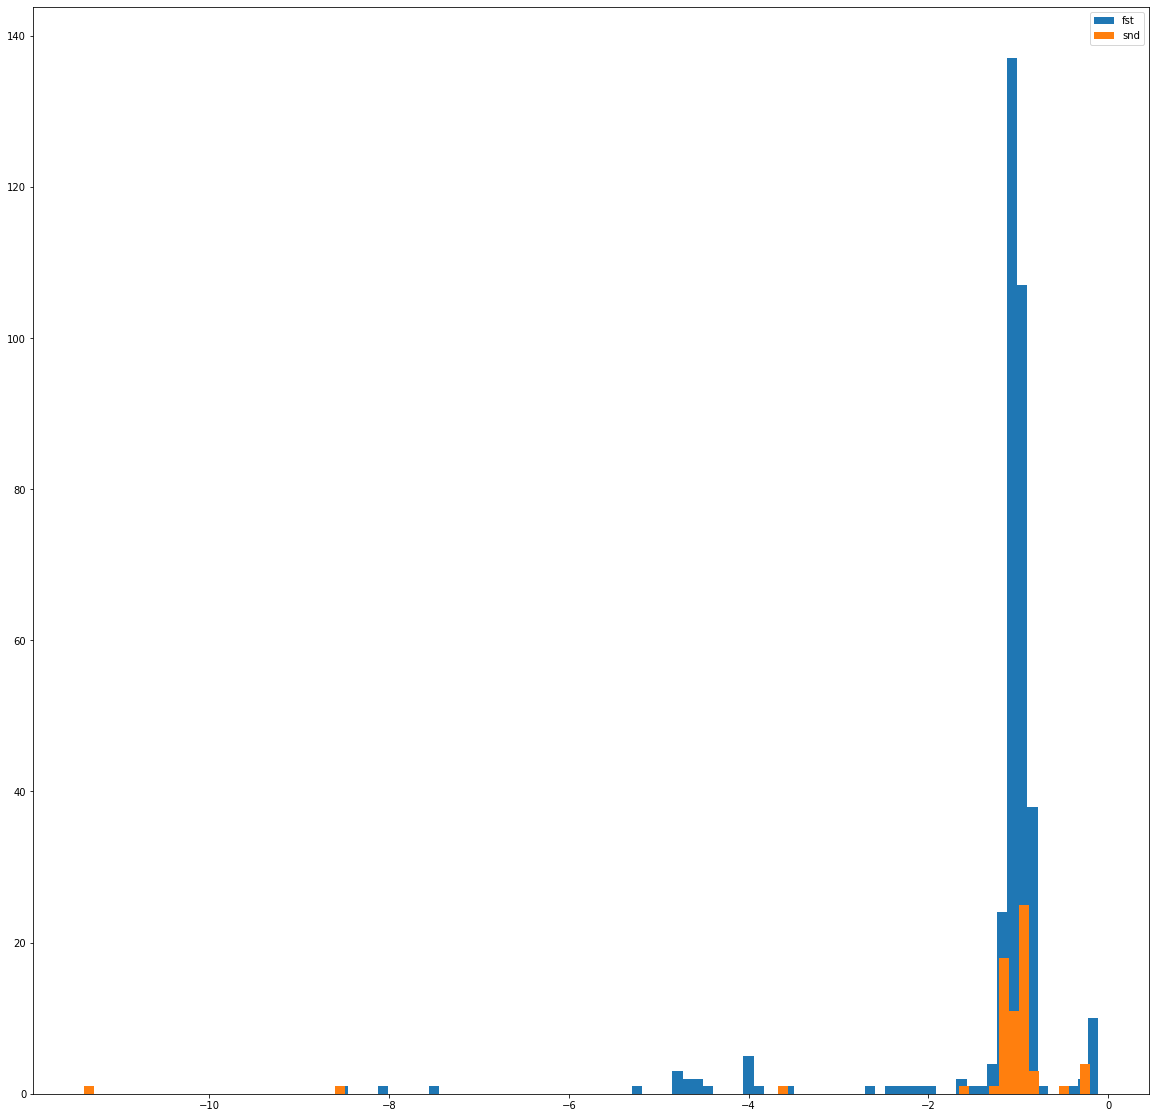

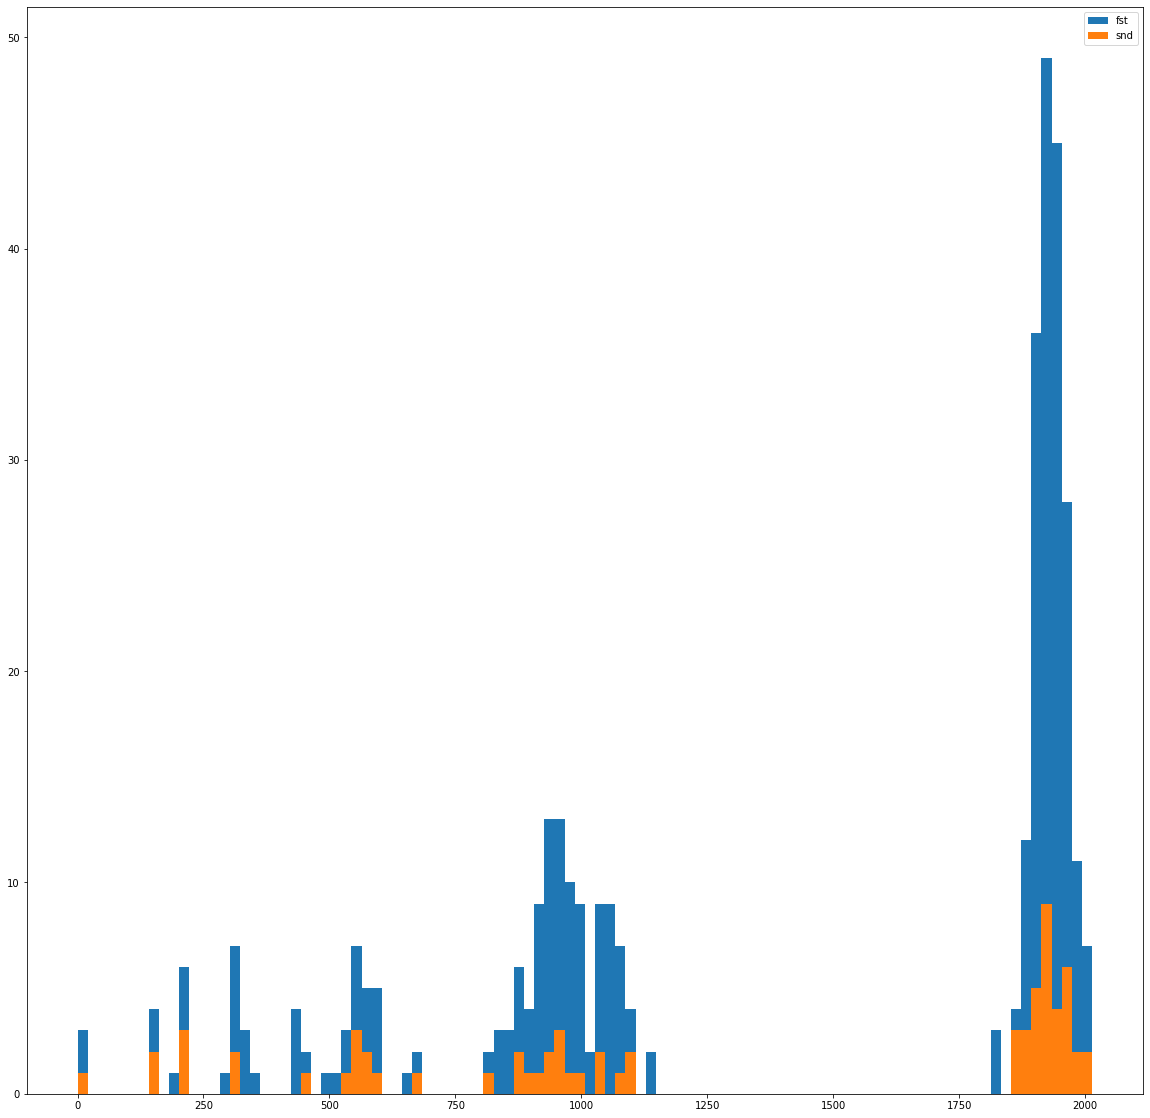

In [22]:
fst_r, snd_r = hdc.analyze(testencoded, testlabels)

print(len(fst_r), len(snd_r))
#beta = max(snd_r)
#fst_r = fst_r[fst_r <= beta]
print(len(fst_r))



fst_mr, snd_mr, fst_scs, snd_scs = hdc.analyze_topn(testencoded, testlabels, dominance, mask_t, mask_d)

print(len(fst_mr), len(snd_mr))
print(len(fst_scs), len(snd_scs))
#print(fst_mr)
#print(snd_mr)
#print(fst_scs)
#print(snd_scs)


plt.figure(figsize = (20, 20))
plt.hist(np.append(fst_mr,snd_mr), bins = 100, label = "fst")
plt.hist(snd_mr, bins = 100, label = "snd")
plt.legend()

plt.figure(figsize = (20, 20))
plt.hist(np.append(fst_scs,snd_scs), bins = 100, label = "fst")
plt.hist(snd_scs, bins = 100, label = "snd")
plt.legend()

In [22]:
np.set_printoptions(threshold=sys.maxsize)